In [1]:
import os,sys,shutil
import numpy as np
import matplotlib.pyplot as plt
import time
from mpm_rect import mpm_rect
from mpm_circ import mpm_circ
from mpm_tria import mpm_tria
sys.path.append(os.getcwd()+'/build')
import MPM_2D
import math
from tqdm import tqdm, trange

In [2]:
#Defining the grid
x_0 = 0; y_0 = 0;                               #Origin of X and Y Axis
lx = 0.4; ly = 0.4;                             #Length of grid in X and Y direction
nx = 15; ny = 15;                               #Number of cells in X and Y direction

Grid = MPM_2D.MPM_Grid(L=[lx, ly], N=[nx, ny], O=[x_0, y_0])
NoNodes = Grid.NoNodes

In [3]:
#Defining the fluid
MPV_fluid =  mpm_rect([0,0], [0.4,0.2], [40,40], 2)
visc = 0.89; density = 997; bulk_mod = 2e3;
Fluid = MPM_2D.MPM_Fluid(visc, density, bulk_mod, MPV_fluid)

MPV_solid =  mpm_tria([0.2,0.2], [0.2,0.2], [10,10], 2)
#Emod = 9e9; Density = 917; Poisson = 0
Emod = 2e5; Density = 917; Poisson = 0.3
Solid = MPM_2D.MPM_STVKSolid(Emod, Density, Poisson, MPV_solid)

Fluid.MPC()[:,18] = -9.81    #Gravity
Solid.MPC()[:,18] = -9.81    #Gravity

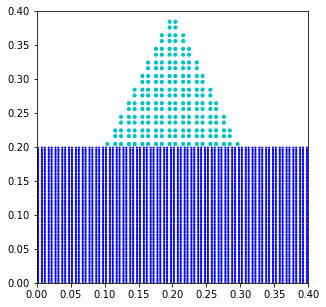

In [6]:
dx = lx/nx; dy = ly/ny
fig, ax = plt.subplots(1, 1, figsize = (5, 5))                                  #creating axis
ax.set_aspect(aspect='equal')
ax.set_xlim(x_0,x_0+lx); ax.set_ylim(y_0,y_0+ly)                                #set limits
ax.scatter(Fluid.MPC()[:,0], Fluid.MPC()[:,1] ,s=Fluid.MPC()[:,4]*1e5,c='b')
ax.scatter(Solid.MPC()[:,0], Solid.MPC()[:,1] ,s=Solid.MPC()[:,4]*1e5,c='c')
#ax.scatter(Solid.MPC()[:,0], Solid.MPC()[:,1] ,s=Solid.MPC()[:,4]*1e4,c='dimgray')
#for i in range (nx+1):
    #ax.plot([x_0+dx*i,x_0+dx*i],[y_0,ly+y_0], c=(0.9, 0.9, 0.9, 1.0) )          #Plot X lines
    #for j in range (ny+1):
        #ax.plot([x_0,lx+x_0],[y_0+dy*j,y_0+dy*j], c=(0.9, 0.9, 0.9, 1.0) )      #Plot Y lines

In [7]:
#Prepare postprocessing
plotstarget_directory = os.path.join(os.getcwd(), "floating_solid_plots")

#Create a new directory to store the plots (delete when there)
if os.path.exists(plotstarget_directory) and os.path.isdir(plotstarget_directory):
    shutil.rmtree(plotstarget_directory)
os.mkdir(plotstarget_directory)
print("Plots will be saved to : ", plotstarget_directory)

def save_plot(current_time):
    dx = lx/nx; dy = ly/ny
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))                                  #creating axis
    ax.set_xlim(x_0,x_0+lx); ax.set_ylim(y_0,y_0+ly)                                #set limits
    # for i in range (nx+1):
    #     ax.plot([x_0+dx*i,x_0+dx*i],[y_0,ly+y_0], c=(0.9, 0.9, 0.9, 1.0) )          #Plot X lines
    #     for j in range (ny+1):
    #         ax.plot([x_0,lx+x_0],[y_0+dy*j,y_0+dy*j], c=(0.9, 0.9, 0.9, 1.0) )      #Plot Y lines
    ax.scatter(Fluid.MPC()[:,0], Fluid.MPC()[:,1] ,s=Fluid.MPC()[:,4]*1e5,c='b')
    ax.scatter(Solid.MPC()[:,0], Solid.MPC()[:,1] ,s=Solid.MPC()[:,4]*1e5,c='c')
    ax.set_aspect(aspect='equal')
    filename = 'Float_'+str(current_time)+'.png'
    fig.savefig(os.path.join(plotstarget_directory, filename), dpi=400, bbox_inches="tight")
    plt.close()                                                                     #prevent plotting in jupyter notebook
    return

Plots will be saved to :  /home/karthik/cpp/mpm_2d_cpp/floating_solid_plots


In [8]:
#Running through time steps
t = 0                                               #start time
alpha = 0                                           #damping factor
T = 10.0; dt = 1e-6                                 #Total time and time step
NoS = int(T/dt)                                     #Number of time steps
noMicroSteps = int(10000)                           #Incremental time step for solver
noMacroSteps = int(NoS/noMicroSteps)                #Number of vtk files

Solver = MPM_2D.MPM_Solver()
Solver.addBC(lambda X: True if (X[0] == 0.0) else False, vx=0.0)
Solver.addBC(lambda X: True if (X[0] == 0.4) else False, vx=0.0)
Solver.addBC(lambda X: True if (X[1] == 0.0) else False, vy=0.0)
Bodies = [Solid, Fluid]

start_time = time.time()
for step in trange (noMacroSteps):
    Solver.Solve(Grid, Bodies, noMicroSteps, dt, alpha)
    save_plot(step+1)
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 1000/1000 [7:49:59<00:00, 28.20s/it]--- 28200.182054758072 seconds ---

